In [164]:
import os
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# add path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# parent_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(parent_dir)
# parent_dir

from src.utils import paths
from src.features import bispectrum
from src.features import powerspectra


In [165]:
seed = 950
redshift = 1

In [166]:
filename = paths.get_pre_computed_bispectra_from_bank(seed, "gr", redshift, type="equilateral")
filename

PosixPath('/mn/stornext/d10/data/johanmkr/simulations/data_analysis/pre_computed_bispectra_bank/seed0950_gr_equilateral_rs0001.csv')

In [167]:
grdF = pd.read_csv(paths.get_pre_computed_bispectra_from_bank(seed, "gr", redshift, type="equilateral"))
newtondF = pd.read_csv(paths.get_pre_computed_bispectra_from_bank(seed, "newton", redshift, type="equilateral"))
grdF.head()

,Unnamed: 0,k,B,Q
0,0,0.001227,-16600.578978,-900.383537
1,1,0.001230,-16343.292405,-927.752360
2,2,0.001232,-16343.292405,-927.752360
3,3,0.001235,-16343.292405,-927.752360
4,4,0.001238,-16343.292405,-927.752360


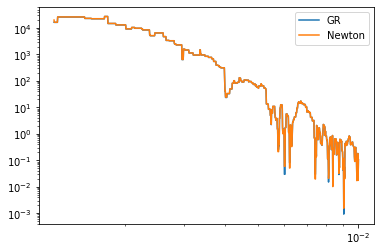

In [168]:
def plot_stuff(grdF, newtondF):
    plt.loglog(grdF["k"], abs(grdF["B"]), label="GR")
    plt.loglog(newtondF["k"], abs(newtondF["B"]), label="Newton")
    # plt.loglog(grdF["k"], grdF["B"], label="GR")
    # plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
    plt.legend()
    plt.show()

plot_stuff(grdF, newtondF)

In [169]:
# Naive rebinning

def naive_rebinning(frame:pd.DataFrame, bin_stride:int=5):
    """Rebin the bispectrum by averaging the values in each bin"""
    k = frame["k"]
    B = frame["B"]
    k_rebinned = []
    B_rebinned = []
    i = 0
    while i < len(k):
        k_rebinned.append(k[i+bin_stride//2]) # Is this correct?
        B_rebinned.append(np.mean(B[i:i+bin_stride]))
        i += bin_stride
    return pd.DataFrame({"k":k_rebinned, "B":B_rebinned})


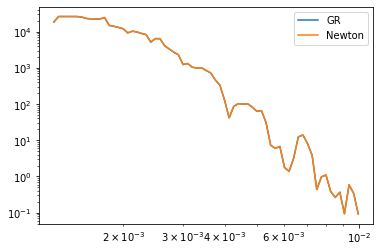

,k,B
0,0.001245,-18299.108933
1,0.001285,-26036.612851
2,0.001326,-26036.612851
3,0.001369,-26036.612851
4,0.001413,-26036.612851
...,...,...
62,0.008779,-0.365937
63,0.009060,0.094521
64,0.009350,0.588388
65,0.009649,0.343109


In [170]:
first_bin_stride = 15
once_rebinned_grdF = naive_rebinning(grdF, bin_stride=first_bin_stride)
once_rebinned_newtondF = naive_rebinning(newtondF, bin_stride=first_bin_stride)

plot_stuff(once_rebinned_grdF, once_rebinned_newtondF)
once_rebinned_grdF

In [171]:
# second_bin_stride = 5
# twice_rebinned_grdF = naive_rebinning(once_rebinned_grdF, bin_stride=second_bin_stride)
# twice_rebinned_newtondF = naive_rebinning(once_rebinned_newtondF, bin_stride=second_bin_stride)

# plot_stuff(twice_rebinned_grdF, twice_rebinned_newtondF)

In [172]:
# thirds_bin_stride = 5
# thrice_rebinned_grdF = naive_rebinning(twice_rebinned_grdF, bin_stride=thirds_bin_stride)
# thrice_rebinned_newtondF = naive_rebinning(twice_rebinned_newtondF, bin_stride=thirds_bin_stride)

# plot_stuff(thrice_rebinned_grdF, thrice_rebinned_newtondF)

# Analytical approach - three level PT


$$
    F_2(\mathbf{k}_1,\mathbf{k}_2) = \frac{5}{7} + \frac{x}{2}\left(\frac{k_1}{k_2}+\frac{k_2}{k_1}\right)+\frac{2}{7}x^2,
$$
with $x=\hat{\mathbf{k}}_1\cdot\hat{\mathbf{k}}_2 = \cos\theta$, where $\theta$ is the angle spanned by $\mathbf{k}_1$ and $\mathbf{k}_2$.

In [173]:
def F2_kernel(k1, k2, angle):
    return 5./7 + 1./2 * (k1/k2 + k2/k1) * np.cos(angle) + 2./7 * (np.cos(angle))**2

def full_F2_output(k, theta_12):
    """The F2 kernel for equilatera and squeezed triangles where k1=k2"""
    alpha = np.pi - theta_12
    k1 = k
    k2 = k
    k3 = np.sqrt(k1**2 + k2**2 - 2*k1*k2*np.cos(alpha))
    
    # Find beta and gamma
    beta = np.arcsin(k1/k3 * np.sin(alpha))
    gamma = np.arcsin(k2/k3 * np.sin(alpha))
    
    # Check that the angles add up to pi
    assert np.isclose(beta + gamma + alpha, np.pi)
    
    # Find remaining thetas
    theta_23 = np.pi - beta 
    theta_13 = np.pi - gamma
    
    # Permutations
    F12 = F2_kernel(k1, k2, theta_12)
    F23 = F2_kernel(k2, k3, theta_23)
    F31 = F2_kernel(k3, k1, theta_13)
    
    return F12, F23, F31, k3
    

In [174]:
grPS = powerspectra.PowerSpectra(paths.get_power_spectra_path(seed, "gr"))
newtonPS = powerspectra.PowerSpectra(paths.get_power_spectra_path(seed, "newton"))

In [175]:
# Spline spectra: 
from scipy import interpolate

def Splined_PS(PS, kind="cubic", **kwargs):
    """Returns a spline interpolation of the power spectra"""
    f = interpolate.interp1d(PS.k, PS.pk, kind=kind, **kwargs)
    return f

grPS_spline = Splined_PS(PS=grPS.get_power_spectrum("phi", redshift), bounds_error=False, fill_value ="extrapolate")
newtonPS_spline = Splined_PS(PS=newtonPS.get_power_spectrum("phi", redshift), bounds_error=False, fill_value ="extrapolate")

In [176]:
def analytical_equilateral_bispectrum():
    k_range = np.geomspace(1e-3, 1e-2, 100)
    B_analytical = []
    for k in k_range:
        F12, F23, F31, k3 = full_F2_output(k, 2*np.pi/3)
        B_value = 2 * F12 * grPS_spline(k) * grPS_spline(k) + 2*F23 * grPS_spline(k) * grPS_spline(k3) + 2*F31 * grPS_spline(k) * grPS_spline(k3)
        B_analytical.append(B_value/k) # why divide by k here
        # print(B_value*1e7)
    return k_range, B_analytical

def analytical_squeezed_bispectrum():
    k_range = np.geomspace(1e-3, 1e-2, 100)
    B_analytical = []
    for k in k_range:
        F12, F23, F31, k3 = full_F2_output(k, 20*np.pi/19)
        B_value = 2 * F12 * grPS_spline(k) * grPS_spline(k) + 2*F23 * grPS_spline(k) * grPS_spline(k3) + 2*F31 * grPS_spline(k) * grPS_spline(k3)
        B_analytical.append(B_value)
    return k_range, B_analytical

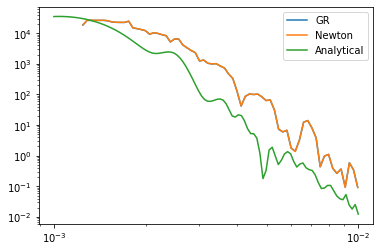

In [177]:
k_anal, B_anal = analytical_equilateral_bispectrum()


plt.loglog(once_rebinned_grdF["k"], abs(once_rebinned_grdF["B"]), label="GR")
plt.loglog(once_rebinned_newtondF["k"], abs(once_rebinned_newtondF["B"]), label="Newton")
plt.loglog(k_anal, B_anal, label="Analytical")
# plt.loglog(grdF["k"], grdF["B"], label="GR")
# plt.loglog(newtondF["k"], newtondF["B"], label="Newton")
plt.legend()
plt.show()